In [18]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [ ]:
model_path = r"C:\Users\Ekaansh\Downloads\668ed88f4121ad584885a2a5_64da35f703a3998e7f2a50a0_image3-min.png"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18()
model.fc = torch.nn.Linear(model.fc.in_features, 10)  # EuroSAT has 10 classes
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

C:\Users\Ekaansh\AppData\Local\Temp\ipykernel_24120\47194640.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [21]:
class GradCAMPP:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = []
        self.activations = []
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations.append(output.detach())

        def backward_hook(module, grad_input, grad_output):
            self.gradients.append(grad_output[0].detach())

        target_module = dict([*self.model.named_modules()])[self.target_layer]
        target_module.register_forward_hook(forward_hook)
        target_module.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor, target_class=None):
        self.gradients = []
        self.activations = []

        output = self.model(input_tensor)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        self.model.zero_grad()
        loss = output[0, target_class]
        loss.backward()

        gradients = self.gradients[-1]  # (B, C, H, W)
        activations = self.activations[-1]  # (B, C, H, W)
        b, k, u, v = gradients.size()

        # Compute alpha
        numerator = gradients.pow(2)
        denominator = 2 * gradients.pow(2) + \
                      torch.sum(activations * gradients.pow(3), dim=(2, 3), keepdim=True)
        denominator = torch.where(denominator != 0.0, denominator, torch.tensor(1.0).to(denominator.device))
        alpha = numerator / denominator

        positive_gradients = F.relu(loss.exp() * gradients)
        weights = torch.sum(alpha * positive_gradients, dim=(2, 3))

        cam = torch.sum(weights.view(b, k, 1, 1) * activations, dim=1)
        cam = F.relu(cam)

        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        cam = cam.squeeze().cpu().numpy()

        return cam

In [23]:
image_path = r"D:\datasets\2750\2750\Pasture\Pasture_2.jpg"
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

In [27]:
from pytorch_grad_cam import GradCAMPlusPlus

# Correct way
gradcampp = GradCAMPlusPlus(
    model=model,
    target_layers=[model.layer4]  # Pass as a list, not a string
)

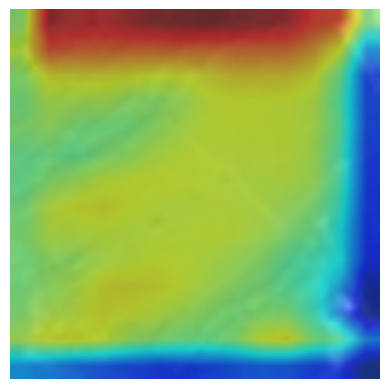

In [29]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layer = model.layer3[-1]  # you said you prefer layer3

cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])

# Generate grayscale heatmap
grayscale_cam = cam(input_tensor=input_tensor)[0]  # [batch_idx]

# Convert to RGB overlay
image_np = np.array(image.resize((224, 224))) / 255.0
visualization = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.axis("off")
plt.show()
